# Assignment 1.5: Regression and Correlation
Which of your Personal Focus Crimes share the most similar weekly rhythm — and which are completely out of sync?


Select at least 4 of your Personal Focus Crimes for this exercise. More is fine - if you want to be closer to the actual weekly exercise.

For each selected crime type, compute the total number of incidents for each of the 168 hours of the week (i.e., Monday 00:00–01:00, Monday 01:00–02:00, ..., Sunday 23:00–00:00). Each crime type will give you a vector of 168 values.

Scatterplot matrix: Create a grid of pairwise scatterplots — one panel per pair of crime types, with one crime on each axis and each of the 168 hours as a point. Label each panel clearly with the two crime types being compared.

Linear regression: Using the closed-form equations from Week 4 (not a library), fit a regression line 
to each pair and add it to the relevant panel
Compute 
for each pair and display the value on each panel.

Looking at your results: which pair of crimes is most correlated? Which is least correlated? Does the answer match your intuition? Why might two crime types share a weekly rhythm — or not?

Available focus groups: ['Property Crime' 'Violent Crime' 'Other/Suspicious' 'Non-Criminal'
 'Financial Crime' 'Drug & Alcohol' 'Administrative' 'Weapons'
 'Sex Offenses' 'Public Order']


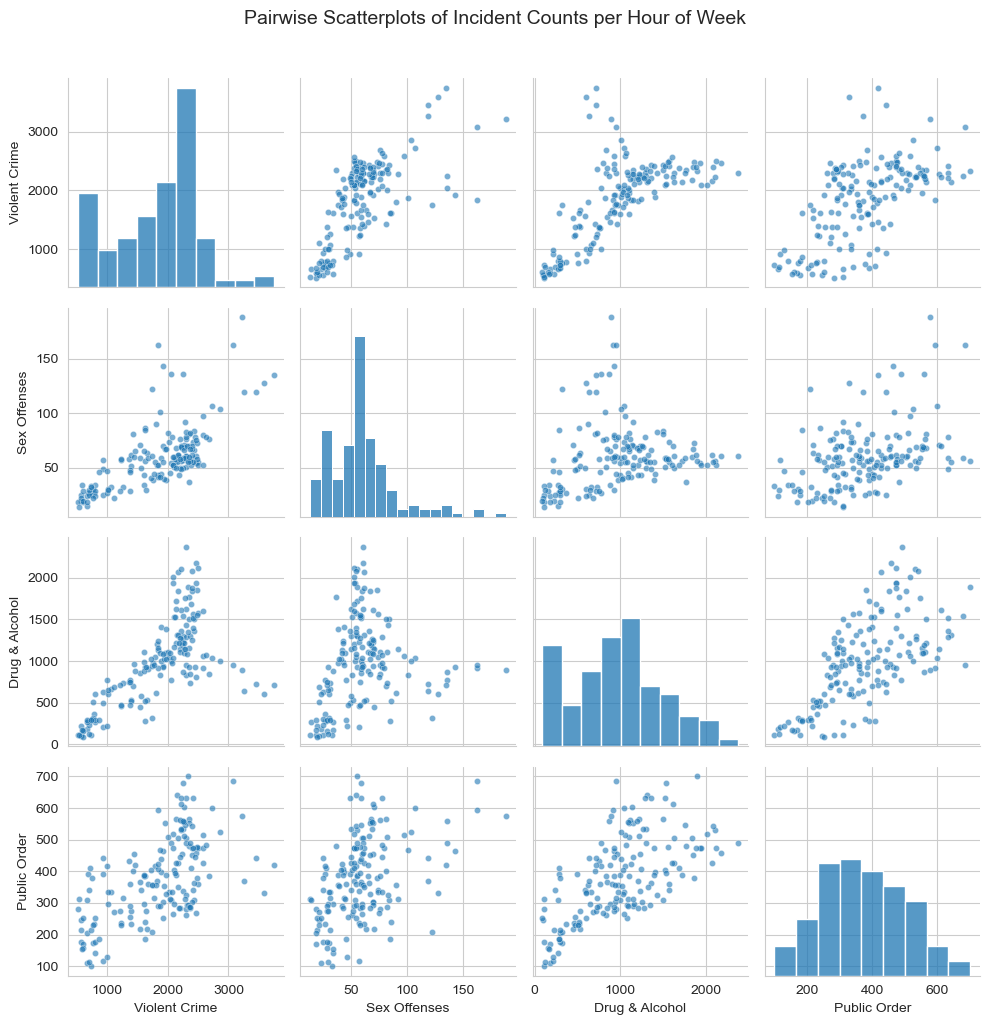

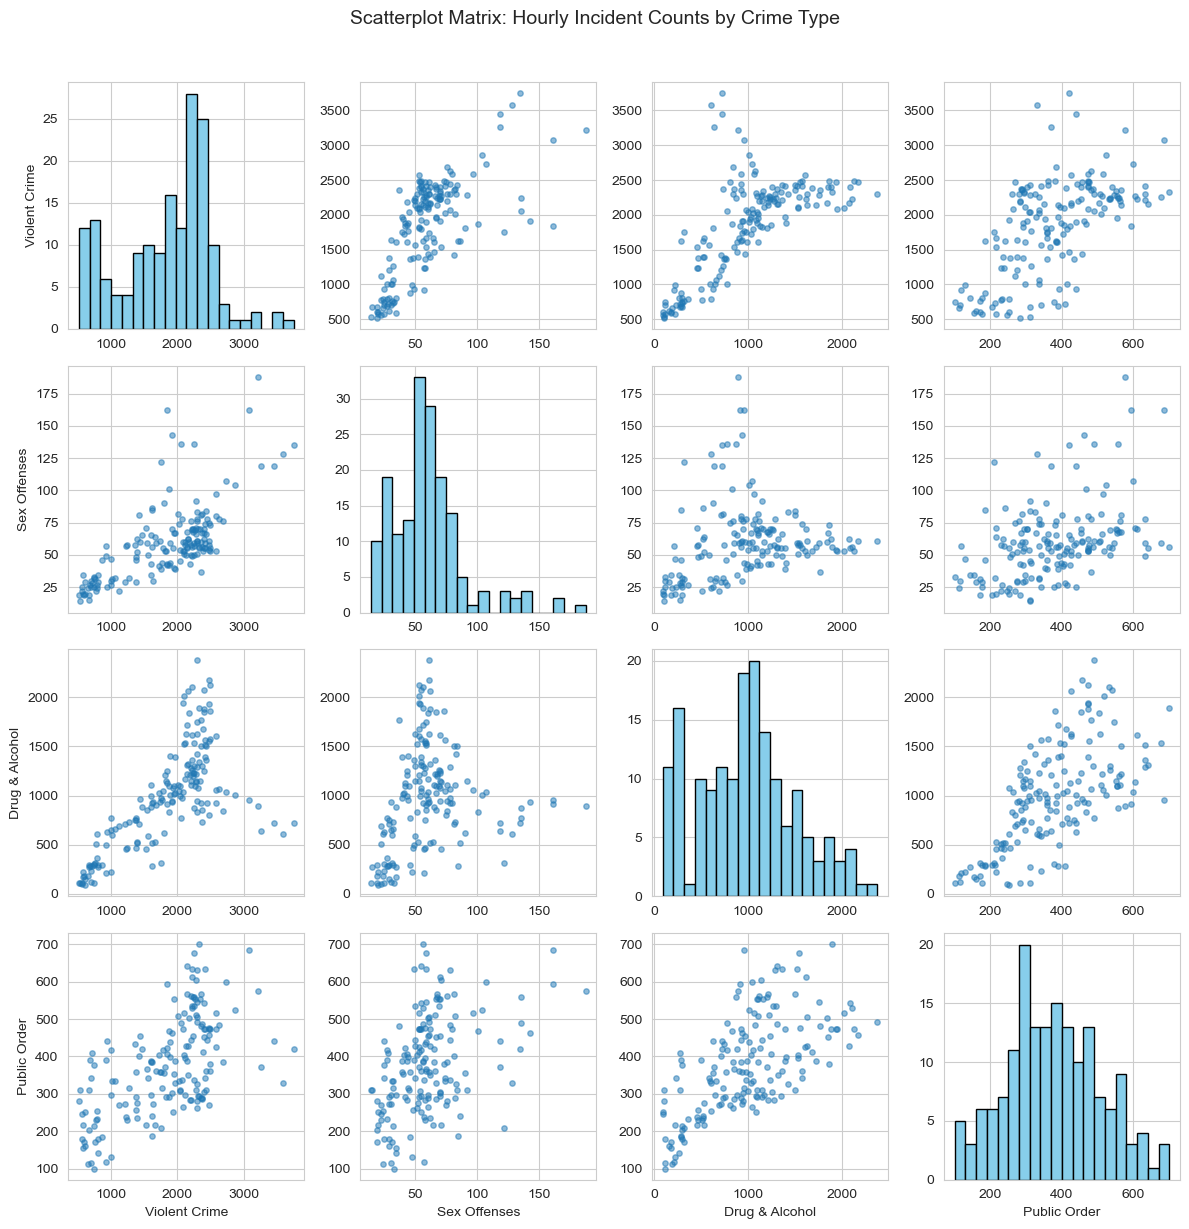

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------
# 1. Load and prepare data
# ------------------------------
data = pd.read_csv("../data/clean-data/sf_clean_data_grouped.csv")

# Convert datetime
data['Incident Datetime'] = pd.to_datetime(data['Incident Datetime'])

# Extract day of week (Monday=0, Sunday=6) and hour
data['day_of_week'] = data['Incident Datetime'].dt.dayofweek  # 0 = Monday
data['hour'] = data['Incident Datetime'].dt.hour

# Create hour-of-week index (0 = Monday 00:00-01:00, ..., 167 = Sunday 23:00-00:00)
data['hour_of_week'] = data['day_of_week'] * 24 + data['hour']

# ------------------------------
# 2. Define the four crime types
# ------------------------------
# Use the exact labels as they appear in your 'Focus Group' column
crime_types = ['Violent Crime', 'Sex Offenses', 'Drug & Alcohol', 'Public Order']

# Verify they exist
print("Available focus groups:", data['Focus Group'].unique())
for ct in crime_types:
    if ct not in data['Focus Group'].values:
        print(f"Warning: '{ct}' not found. Check spelling.")

# ------------------------------
# 3. Build the 168-hour vectors for each crime type
# ------------------------------
# Create an empty DataFrame with hour_of_week as index
hour_range = np.arange(168)
crime_counts = pd.DataFrame(index=hour_range)

for crime in crime_types:
    # Filter data for this crime
    crime_data = data[data['Focus Group'] == crime]
    # Count incidents per hour_of_week
    counts = crime_data.groupby('hour_of_week').size()
    # Reindex to include all 168 hours, fill missing with 0
    counts = counts.reindex(hour_range, fill_value=0)
    crime_counts[crime] = counts.values

# ------------------------------
# 4. Create scatterplot matrix
# ------------------------------
# Use seaborn's pairplot for a quick matrix
sns.set_style("whitegrid")
g = sns.pairplot(crime_counts, diag_kind='hist', plot_kws={'alpha':0.6, 's':20})
g.fig.suptitle('Pairwise Scatterplots of Incident Counts per Hour of Week', y=1.02, fontsize=14)

plt.tight_layout()
plt.show()

# ------------------------------
# 5. (Optional) Manual scatterplot matrix with more control
# ------------------------------
# If you prefer a custom matrix with labelled axes and panels:
fig, axes = plt.subplots(len(crime_types), len(crime_types), figsize=(12, 12))

for i, crime_i in enumerate(crime_types):
    for j, crime_j in enumerate(crime_types):
        ax = axes[i, j]
        if i == j:
            # Diagonal: histogram
            ax.hist(crime_counts[crime_i], bins=20, color='skyblue', edgecolor='black')
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            # Off-diagonal: scatter
            ax.scatter(crime_counts[crime_j], crime_counts[crime_i], alpha=0.5, s=15)
            ax.set_xlabel('')
            ax.set_ylabel('')
        # Label rows and columns
        if i == len(crime_types)-1:
            ax.set_xlabel(crime_j, fontsize=10)
        if j == 0:
            ax.set_ylabel(crime_i, fontsize=10)

plt.suptitle('Scatterplot Matrix: Hourly Incident Counts by Crime Type', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

Available focus groups: ['Property Crime' 'Violent Crime' 'Other/Suspicious' 'Non-Criminal'
 'Financial Crime' 'Drug & Alcohol' 'Administrative' 'Weapons'
 'Sex Offenses' 'Public Order']


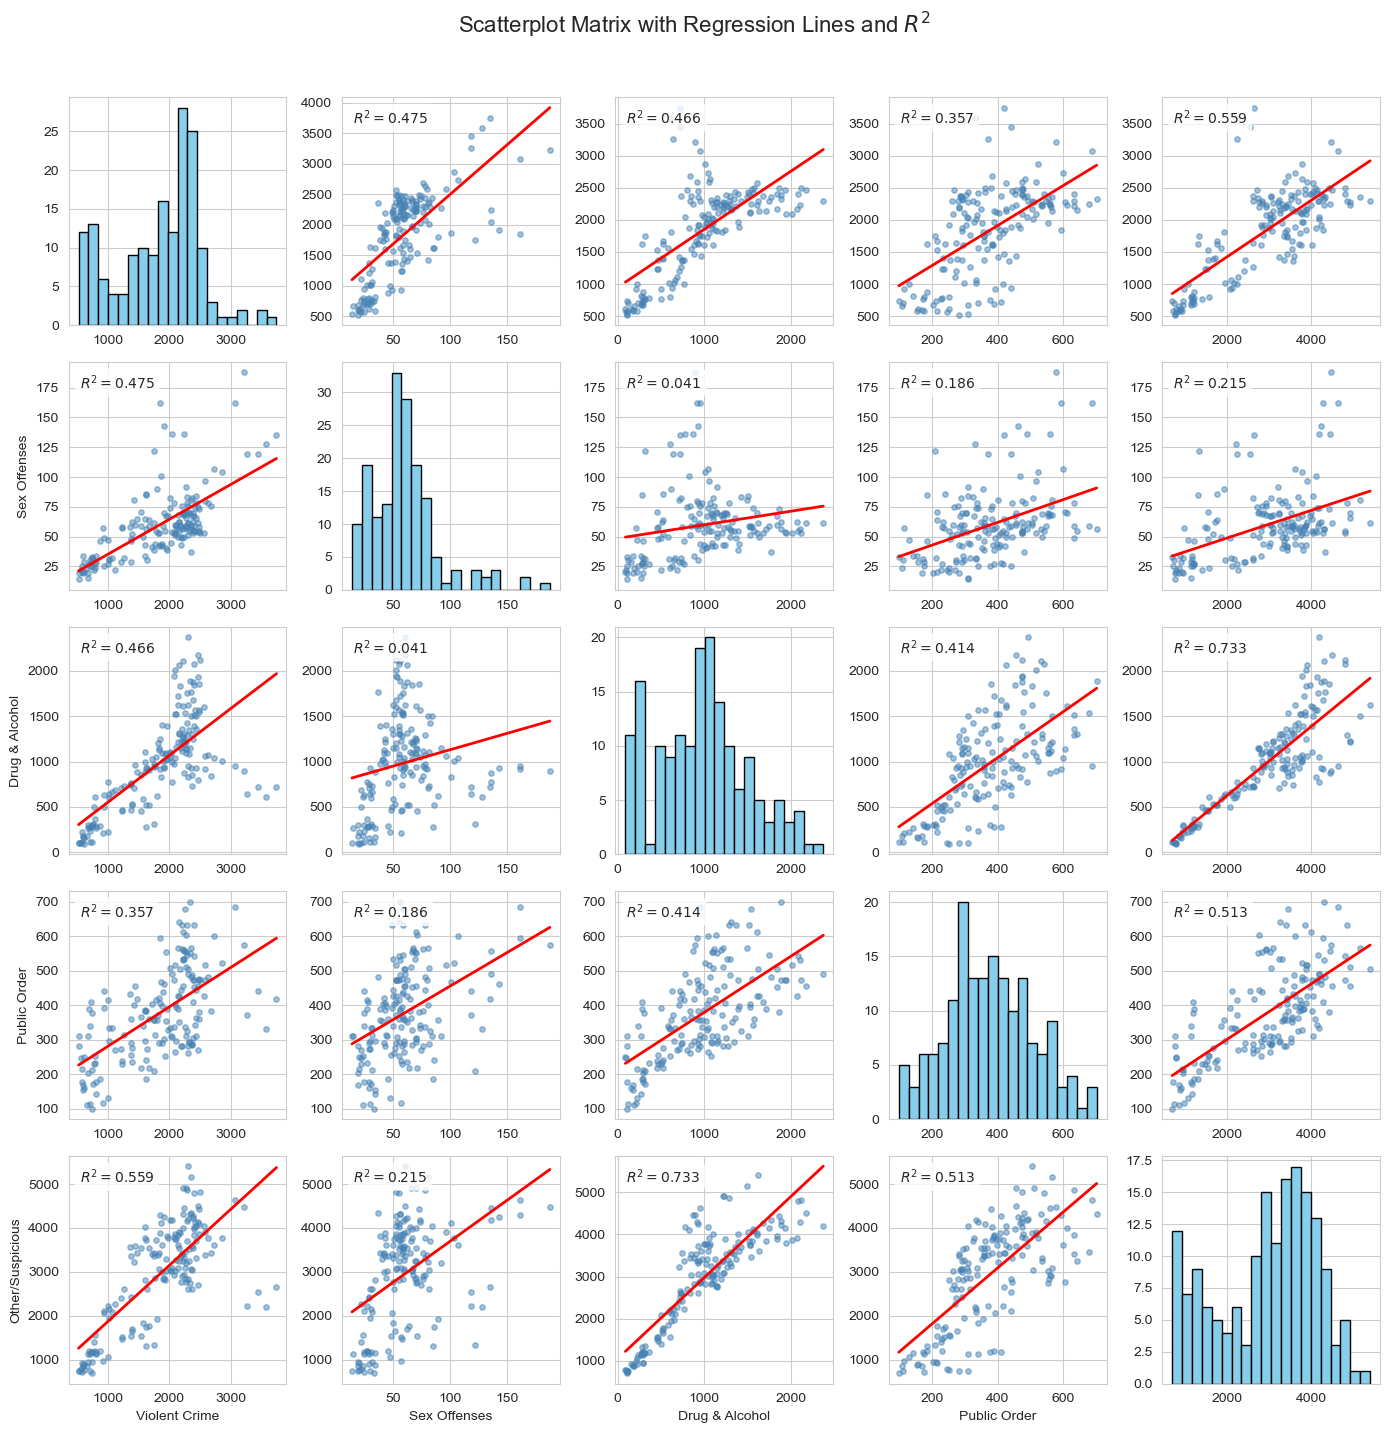

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# 1. Load and prepare data
# ------------------------------
data['Incident Datetime'] = pd.to_datetime(data['Incident Datetime'])
data['day_of_week'] = data['Incident Datetime'].dt.dayofweek   # 0=Monday
data['hour'] = data['Incident Datetime'].dt.hour
data['hour_of_week'] = data['day_of_week'] * 24 + data['hour']

# ------------------------------
# 2. Define the four crime types
# ------------------------------
crime_types = ['Violent Crime', 'Sex Offenses', 'Drug & Alcohol', 'Public Order', 'Other/Suspicious']
# Verify they exist
print("Available focus groups:", data['Focus Group'].unique())

# ------------------------------
# 3. Build 168‑hour vectors for each crime type
# ------------------------------
hour_range = np.arange(168)
crime_counts = pd.DataFrame(index=hour_range)

for crime in crime_types:
    crime_data = data[data['Focus Group'] == crime]
    counts = crime_data.groupby('hour_of_week').size()
    counts = counts.reindex(hour_range, fill_value=0)
    crime_counts[crime] = counts.values

# ------------------------------
# 4. Create scatterplot matrix with regression lines and R²
# ------------------------------
fig, axes = plt.subplots(len(crime_types), len(crime_types), figsize=(14, 14))

for i, crime_i in enumerate(crime_types):
    for j, crime_j in enumerate(crime_types):
        ax = axes[i, j]
        x = crime_counts[crime_j].values   # column crime_j on x-axis
        y = crime_counts[crime_i].values   # row crime_i on y-axis

        if i == j:
            # Diagonal: histogram
            ax.hist(x, bins=20, color='skyblue', edgecolor='black')
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            # Off-diagonal: scatter plot
            ax.scatter(x, y, alpha=0.5, s=15, color='steelblue')

            # --- Linear regression using closed-form equations ---
            N = len(x)
            mean_x = np.mean(x)
            mean_y = np.mean(y)

            # Slope a = (Σxy - N * mean_x * mean_y) / (Σx² - N * mean_x²)
            numerator = np.sum(x * y) - N * mean_x * mean_y
            denominator = np.sum(x**2) - N * mean_x**2
            if denominator != 0:
                a = numerator / denominator
            else:
                a = 0   # constant x (unlikely)

            # Intercept b = mean_y - a * mean_x
            b = mean_y - a * mean_x

            # Plot regression line
            x_line = np.array([x.min(), x.max()])
            y_line = a * x_line + b
            ax.plot(x_line, y_line, color='red', linewidth=2)

            # --- Compute R² ---
            # Total sum of squares (around mean)
            ss_tot = np.sum((y - mean_y)**2)
            # Residual sum of squares
            ss_res = np.sum((y - (a*x + b))**2)
            if ss_tot != 0:
                r2 = 1 - ss_res / ss_tot
            else:
                r2 = np.nan

            # Display R² on the panel
            ax.text(0.05, 0.95, f'$R^2 = {r2:.3f}$',
                    transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Set axis labels only on outer edges
            if i == len(crime_types)-1:
                ax.set_xlabel(crime_j, fontsize=10)
            if j == 0:
                ax.set_ylabel(crime_i, fontsize=10)

plt.suptitle('Scatterplot Matrix with Regression Lines and $R^2$', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

The correlation analysis of the chosen five Focus Groups showed that Drugs and Alcohol are strongly correlated with Other or Suspicious activity with R^2 = 0.733. The group Other is also highly correlated with all the other analysed crimes. This can be explained that the reported activity include suicide .....
Next strong correlation can be seen between Violent Crime and Sex offense. Both of these crimes are happening mostly during night hours so this result was expected. The smallest correlation was found between Drugs and Alcohol and Sex offense. This was expected as from the plots on Asignment 3, hours when these crimes happen vary a lot.